In [2]:
""" 
Predicción de Salarios en Data Science - Entrenamiento del Modelo

En este notebook, vamos a preparar los datos y entrenar un modelo de Machine Learning
para predecir los salarios en USD de profesionales en Data Science.

Objetivos:
- Cargar y limpiar los datos para que sean más fáciles de usar.
- Dividir los datos en dos partes: una para entrenar el modelo y otra para probarlo.
- Aplicar una transformación a los salarios para reducir el impacto de sueldos muy altos o muy bajos en el modelo.
- Agrupar categorías con pocos datos para mejorar las predicciones.
- Usar `RandomForestRegressor` para entrenar un modelo de predicción de salarios.
- Probar diferentes configuraciones del modelo para encontrar la mejor.
- Guardar el modelo entrenado para hacer predicciones en Pipelines_II.ipynb
"""
import sys
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import dump

"""
1 Cargar y limpiar los datos

Primero, cargamos los datos de salarios y les aplicamos una limpieza básica.
Eliminamos datos duplicados o nulos y estandarizamos los nombres de las columnas.

"""
# Configuración del entorno
sys.path.append(os.path.abspath('..'))  # Añadimos la ruta del directorio padre

# Importamos funciones propias de limpieza de datos
from FUNCIONES.Funciones_limpieza import load_data, clean_data

# Cargar y limpiar los datos
df = load_data("ds_salaries.csv")  # Cargamos el dataset original
df_clean = clean_data(df)  # Aplicamos limpieza de datos

"""
2 Dividir los datos en entrenamiento y prueba

Para asegurarnos de que el modelo realmente funciona, dividimos los datos en dos partes:
- 80% para entrenar el modelo
- 20% para probarlo y ver qué tan bien predice

"""
# Dividir en entrenamiento (80%) y prueba (20%)
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=42)

# Guardar los archivos de entrenamiento y prueba
df_train.to_csv("../data/ds_salaries_train.csv", index=False)
df_test.to_csv("../data/ds_salaries_test.csv", index=False)

print(" Datos divididos correctamente en entrenamiento y prueba.")
print(f"Train: {df_train.shape[0]} filas")
print(f"Test: {df_test.shape[0]} filas")

# Cargar los datos de entrenamiento en vez del dataset completo
df_train = load_data("ds_salaries_train.csv")
df_clean_train = clean_data(df_train)  # Aplicar limpieza
""" 
3 Transformación del salario y agrupación de categorías

Algunos salarios son muy altos y pueden afectar el modelo, así que aplicamos una transformación logarítmica:

df_clean_train['salary_in_usd'] = np.log1p(df_clean_train['salary_in_usd'])

También reducimos el número de categorías en `job_title` y `company_location` para evitar problemas con valores poco frecuentes

"""
# Aplicar transformación logarítmica al salario
df_clean_train['salary_in_usd'] = np.log1p(df_clean_train['salary_in_usd'])

# Agrupar categorías en job_title y company_location
top_jobs = df_clean_train['job_title'].value_counts().index[:10]
df_clean_train['job_title'] = df_clean_train['job_title'].apply(lambda x: x if x in top_jobs else 'Other')

top_locations = df_clean_train['company_location'].value_counts().index[:10]
df_clean_train['company_location'] = df_clean_train['company_location'].apply(lambda x: x if x in top_locations else 'Other')

""" 
4 Preparar los datos para el modelo**

Aquí seleccionamos las variables que usaremos para entrenar el modelo. Las dividimos en dos grupos:
- **Variables numéricas:** `work_year`
- **Variables categóricas:** `experience_level`, `job_title`, `company_location`, `company_size`

Para que el modelo entienda los datos, hacemos lo siguiente:
- scalamos la variable numérica `work_year`.
- Convertimos las variables categóricas en números usando `OneHotEncoder`.


"""


# Definir variables predictoras (X) y target (y)
X = df_clean_train[['work_year', 'experience_level', 'job_title', 'company_location', 'company_size']]
y = df_clean_train['salary_in_usd']

# Preprocesamiento de los datos
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['work_year']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['experience_level', 'job_title', 'company_location', 'company_size'])
])
""" 
5 Entrenar el modelo de predicción

Usamos RandomForestRegressor, un modelo que funciona bien con este tipo de datos.

Probamos diferentes configuraciones del modelo para encontrar la mejor combinación de parámetros

Entrenamos el modelo con estas configuraciones y usamos GridSearchCV para encontrar la mejor

"""
#  Definición del modelo: RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Optimización de hiperparámetros
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Entrenamiento del modelo con GridSearchCV
print("Iniciando entrenamiento del modelo con GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)
print("Entrenamiento completado")

# Resultados de la optimización
print("Mejor modelo encontrado:", grid_search.best_estimator_)
print(" Mejores hiperparámetros:", grid_search.best_params_)
print(" Mejor puntuación (MSE):", grid_search.best_score_)

""" 
6 Guardar el modelo entrenado

Guardamos el mejor modelo encontrado para usarlo en Pipelines_II.ipynb

"""
# Guardado del modelo entrenado
model_path = "../models/pipeline_model.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
dump(grid_search.best_estimator_, model_path)
print(f" Modelo guardado correctamente en {model_path}")

✅ Archivo 'ds_salaries.csv' cargado correctamente. Dimensiones: (3755, 11)
🔹 Se han eliminado duplicados. Dimensiones actuales: (2584, 11)
🔹 Se han eliminado valores nulos. Dimensiones actuales: (2584, 11)
🔹 Los nombres de las columnas han sido normalizados.
 Datos divididos correctamente en entrenamiento y prueba.
Train: 2067 filas
Test: 517 filas
✅ Archivo 'ds_salaries_train.csv' cargado correctamente. Dimensiones: (2067, 11)
🔹 Se han eliminado duplicados. Dimensiones actuales: (2067, 11)
🔹 Se han eliminado valores nulos. Dimensiones actuales: (2067, 11)
🔹 Los nombres de las columnas han sido normalizados.
Iniciando entrenamiento del modelo con GridSearchCV...
Entrenamiento completado
Mejor modelo encontrado: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['work_year']),
                                                 ('cat',
                                                

Explicacion de los resultados de limpieza: 
Datos originales: el archivo inicial (ds_salaries.csv) tenía 3755 filas y 11 columnas y tras eliminar los datos duplicados, se redujo a 2584 filas.
No se encontraron valores nulos adicionales y se normalizaron los nombres de columnas

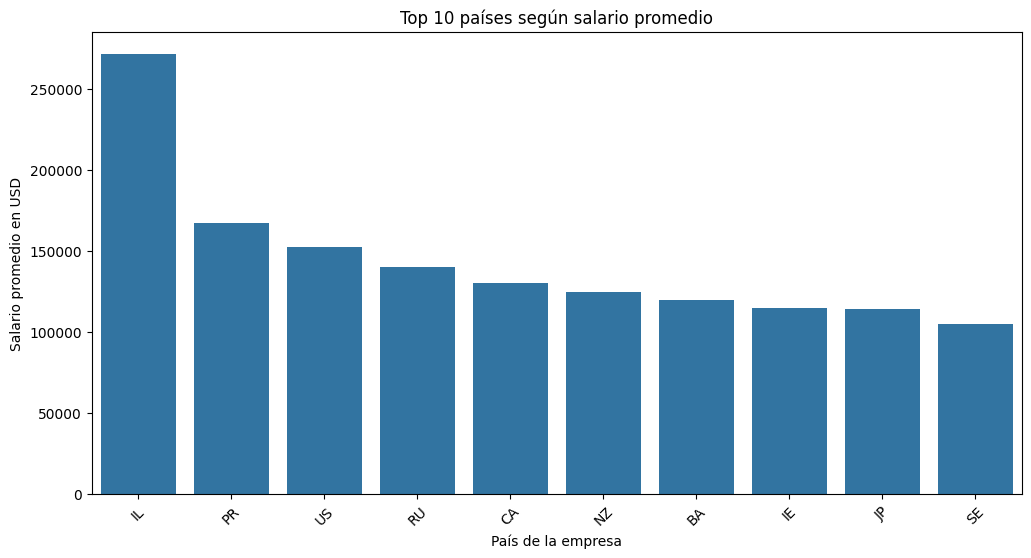

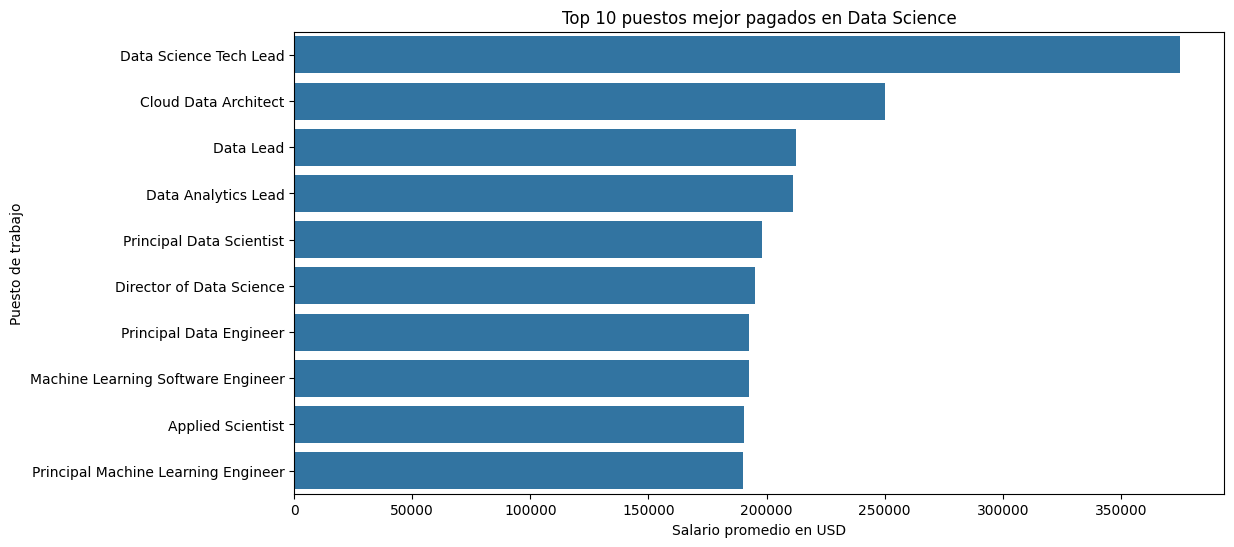

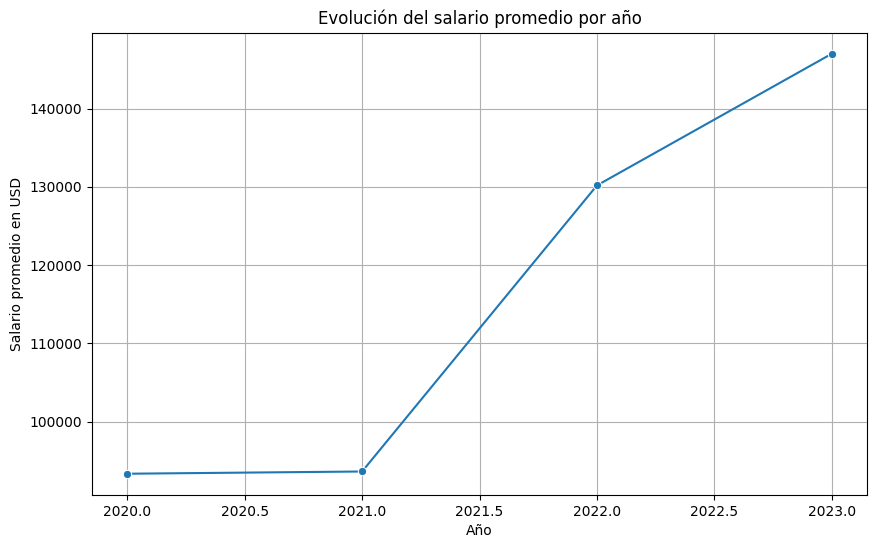

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Gráfica 1: Salario promedio según el país de la empresa top 10
plt.figure(figsize=(12, 6))
top_locations = df_clean.groupby('company_location')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Top 10 países según salario promedio')
plt.xlabel('País de la empresa')
plt.ylabel('Salario promedio en USD')
plt.xticks(rotation=45)
plt.show()

# Gráfica 2: Salario promedio según el puesto de trabajo top 10
plt.figure(figsize=(12, 6))
top_jobs = df_clean.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(y=top_jobs.index, x=top_jobs.values)
plt.title('Top 10 puestos mejor pagados en Data Science')
plt.xlabel('Salario promedio en USD')
plt.ylabel('Puesto de trabajo')
plt.show()

# Gráfica 3: Evolución del salario promedio por año
plt.figure(figsize=(10, 6))
salary_year = df_clean.groupby('work_year')['salary_in_usd'].mean().reset_index()
sns.lineplot(x='work_year', y='salary_in_usd', data=salary_year, marker='o')
plt.title('Evolución del salario promedio por año')
plt.xlabel('Año')
plt.ylabel('Salario promedio en USD')
plt.grid(True)
plt.show()



## 1er Gráfico
**Esto ayuda a identificar países con mejores oportunidades económicas para profesionales del área.**  
Puede ser útil para profesionales que consideren trabajar en el extranjero o empresas que quieran competir globalmente ofreciendo mejores salarios.

## 2do Gráfico
**Esta gráfica nos muestra claramente los puestos específicos en el campo de Data Science que ofrecen los salarios más altos.**  
Destaca qué roles están siendo más valorados económicamente en el mercado, permitiendo identificar claramente hacia dónde enfocar esfuerzos profesionales para maximizar ingresos.

## 3er Gráfico
**Se observa cómo ha evolucionado el salario promedio en el sector Data Science en los últimos años.**  
Nos permite concluir si la tendencia salarial está creciendo, estable o en declive, dando una idea clara del futuro económico de esta profesión.
